# Predicting Hotel Booking Cancellation







We're here today to talk about a significant challenge facing the hotel industry: the rising rate of booking cancellations. In recent years, the way people book hotels has dramatically shifted, with a majority of reservations now made through Online Travel Agencies. While this offers convenience, it has also led to customers becoming accustomed to flexible, often free, cancellation policies.

This shift has a Clear impact, leading to significant revenue loss for hotels and OTAs. Studies show that cancellation rates have been steadily increasing, reaching almost 40% in recent years. This makes it incredibly difficult for hotels to accurately forecast demand, resulting in no predictive insight into future occupancy.

Beyond the financial implications, these high cancellation rates create operational challenges for hotels, including difficulties in managing seasonal fluctuations and significant overbooking risks. This can lead to inefficient staffing, wasted resources, and ultimately, a negative impact on guest experience. As we know, online reviews, influenced by platforms like TripAdvisor, play a massive role in travel spending and a hotel's revenue. Avoiding negative experiences caused by cancellations is crucial for maintaining a positive online reputation.

This highlights a critical need for better tools and strategies to understand and predict booking cancellations. Our project aims to address this crucial problem...

## Loading Data

### Library Imports

In [ ]:
#!pip install kmodes


In [ ]:
#!pip install scikeras[tensorflow]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle


#from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from scikeras.wrappers import KerasRegressor

# from tensorflow.keras.callbacks import EarlyStopping

RANDOM_STATE = 42

In [ ]:
pd.set_option('display.max_columns', None)

### Hotel Data Imports

In [ ]:
df = pd.read_csv('hotel_bookings.csv')
df.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
81075,City Hotel,0,8,2015,December,49,1,0,2,1,0.0,0,BB,ESP,Direct,Direct,0,0,0,A,A,0,No Deposit,14.0,NaN,0,Transient-Party,75.00,0,0,Check-Out,2015-12-03
86595,City Hotel,0,5,2016,April,14,1,2,3,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,9.0,NaN,0,Transient,141.00,0,2,Check-Out,2016-04-06
56083,City Hotel,1,92,2016,August,36,28,2,3,2,0.0,0,SC,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,85.0,NaN,0,Transient,63.75,0,0,Canceled,2016-05-30
58028,City Hotel,1,167,2016,October,41,5,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,83.0,NaN,0,Transient,78.20,0,0,Canceled,2016-04-25
97292,City Hotel,0,346,2016,September,38,13,0,2,2,0.0,0,HB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient-Party,115.00,0,1,Check-Out,2016-09-15


In [ ]:
df.shape

(119390, 32)

In [ ]:
df.isnull().sum().sum()

np.int64(129425)

### Data Dictionary


|**Feature Name**|**Type**|**Description**|
|:---|:---|:---|
|ADR|Float|Average Daily Rate. Calculated by dividing the sum of all lodging transactions by the total number of staying nights.|
|Adults|Integer|Number of adults.|
|Agent|Categorical|ID of the travel agency that made the booking.|
|ArrivalDateDayOfMonth|Integer|Day of the month of the arrival date.|
|ArrivalDateMonth|Categorical|Month of arrival date with 12 categories: “January” to “December”.|
|ArrivalDateWeekNumber|Integer|Week number of the arrival date.|
|ArrivalDateYear|Integer|Year of arrival date.|
|AssignedRoomType|Categorical|Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.|
|Babies|Integer|Number of babies.|
|BookingChanges|Integer|Number of changes/amendments made to the booking from the moment the booking was entered on the Property Management System until the moment of check-in or cancellation. Calculated by adding the number of unique iterations that change some of the booking attributes, namely: persons, arrival date, nights, reserved room type or meal.|
|Children|Integer|Number of children. Sum of both payable and non-payable children.|
|Company|Categorical|ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons.|
|Country|Categorical|Country of origin. Categories are represented in the International Standards Organization (ISO) 3155–3:2013 format.|
|CustomerType|Categorical|Type of booking, assuming one of four categories: Contract (when the booking has an allotment or other type of contract associated to it), Group (when the booking is associated to a group), Transient (when the booking is not part of a group or contract, and is not associated to other transient booking), and Transient-party (when the booking is transient, but is associated to at least other transient booking).|
|DaysInWaitingList|Integer|Number of days the booking was in the waiting list before it was confirmed to the customer. Calculated by subtracting the date the booking was confirmed to the customer from the date the booking entered on the Property Management System.|
|DepositType|Categorical|Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit (no deposit was made), Non Refund (a deposit was made in the value of the total stay cost), and Refundable (a deposit was made with a value under the total cost of stay). Value calculated based on the payments identified for the booking in the transaction (TR) table before the booking׳s arrival or cancellation date. In case no payments were found the value is “No Deposit”. If the payment was equal or exceeded the total cost of stay, the value is set as “Non Refund”. Otherwise the value is set as “Refundable”.|
|DistributionChannel|Categorical|Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”.|
|IsCanceled|Integer|Value indicating if the booking was canceled (1) or not (0).|
|IsRepeatedGuest|Integer|Value indicating if the booking name was from a repeated guest (1) or not (0). Variable created by verifying if a profile was associated with the booking customer. If so, and if the customer profile creation date was prior to the creation date for the booking on the Property Management System database it was assumed the booking was from a repeated guest.|
|LeadTime|Integer|Number of days that elapsed between the entering date of the booking into the Property Management System and the arrival date. Calculated by subtracting the entering date from the arrival date.|
|MarketSegment|Categotical|Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”.|
|Meals|Categorical|Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC (no meal package), BB (Bed & Breakfast), HB (Half board: breakfast and one other meal – usually dinner), and FB (Full board: breakfast, lunch and dinner).|
|PreviousBookingsNotCanceled|Integer|Number of previous bookings not canceled by the customer prior to the current booking. In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and not canceled.|
|PreviousCancellations|Integer|Number of previous bookings that were canceled by the customer prior to the current booking. In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and canceled.|
|RequiredCarParkingSpaces|Integer|Number of car parking spaces required by the customer.|
|ReservationStatus|Categorical|Reservation last status, assuming one of three categories: Canceled (booking was canceled by the customer), Check-Out (customer has checked in but already departed), No-Show (customer did not check-in and did inform the hotel of the reason why).
|ReservationStatusDate|Date|Date at which the last status was set. This variable can be used in conjunction with the `ReservationStatus` to understand when was the booking canceled or when did the customer checked-out of the hotel.|
|ReservedRoomType|Categorical|Code of room type reserved. Code is presented instead of designation for anonymity reasons.|
|StaysInWeekendNights|Integer|Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel. Calculated by counting the number of weekend nights from the total number of nights.|
|StaysInWeekNights|Integer|Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel. Calculated by counting the number of week nights from the total number of nights.|
|TotalOfSpecialRequests|Integer|Number of special requests made by the customer (e.g. twin bed or high floor).|

## Data Cleaning

### Missing Data

As models cannot take in null values, it is important to check for and handle missing data before modeling.

In [ ]:
# Checking for missing data
df.isnull().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [ ]:
# Changing agent value of "NULL" to "No Agent":
df['agent'].fillna('No Agent',inplace=True)

/tmp/ipython-input-1246648121.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['agent'].fillna('No Agent',inplace=True)
/tmp/ipython-input-1246648121.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No Agent' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['agent'].fillna('No Agent',inplace=True)


In [ ]:
# Changing company value of "NULL" to "No Company":
df['company'].fillna('No Company',inplace=True)


/tmp/ipython-input-1485181923.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['company'].fillna('No Company',inplace=True)
/tmp/ipython-input-1485181923.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No Company' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['company'].fillna('No Company',inplace=True)


In [ ]:
df.dropna(subset=['children'], inplace=True)

In [ ]:
# Replacing null value for country feature with "unknown"
df['country'].fillna("unknown", inplace=True)

/tmp/ipython-input-1681559495.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['country'].fillna("unknown", inplace=True)


In [ ]:
# Checking that no missing values remain:
df.isnull().sum().sum()

np.int64(0)

Our dataset no longer contains any missing values.

### Data Types

In [ ]:
# Checking our features' data types:
df.dtypes

,0
hotel,object
is_canceled,int64
lead_time,int64
arrival_date_year,int64
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64


### Duplicates

Given the data was obtained directly from the hotel's Property Management Systems, we do not expect any duplicates. However, it is good practice to ensure our dataset does not contain duplicates.

In [ ]:
# Checking for duplicates:
df[df.duplicated(keep='first')]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,No Company,0,Transient,98.00,0,1,Check-Out,2015-07-03
22,Resort Hotel,0,72,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,1,No Deposit,250.0,No Company,0,Transient,84.67,0,1,Check-Out,2015-07-07
43,Resort Hotel,0,70,2015,July,27,2,2,3,2,0.0,0,HB,ROU,Direct,Direct,0,0,0,E,E,0,No Deposit,250.0,No Company,0,Transient,137.00,0,1,Check-Out,2015-07-07
138,Resort Hotel,1,5,2015,July,28,5,1,0,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,240.0,No Company,0,Transient,97.00,0,0,Canceled,2015-07-01
200,Resort Hotel,0,0,2015,July,28,7,0,1,1,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,No Company,0,Transient,109.80,0,3,Check-Out,2015-07-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,City Hotel,0,186,2017,August,35,31,0,3,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,No Company,0,Transient,126.00,0,2,Check-Out,2017-09-03
119352,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,No Company,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
119353,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,No Company,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
119354,City Hotel,0,63,2017,August,35,31,0,3,3,0.0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,No Company,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03


Our dataset contains duplicates. However, it is possible that multiple bookings with the same features were made on the same day. Since we do not have a feature such as "booking ID", we cannot say for sure that those are true duplicates which makes deleting those "duplicates" questionable.  


In [ ]:
count = (df['adr'] <= 0).sum()
print("Number of rows with adr == 0:", count)

Number of rows with adr == 0: 1960


In [ ]:
#we have to drop these rows as average daily rate wuth <0 doesn't make any sence
print("Before:", df.shape)
df = df[df['adr'] > 0]
print("After:", df.shape)


Before: (119386, 32)
After: (117426, 32)


In [ ]:
len(df[df['adults']==0])
## This tells you how many bookings in our dataset have zero adults,
# which is usually an illogical booking because at least one adult should be present.

248

In [ ]:
filter1=(df['adults']==0)
data=df[~filter1]
#remove the rows that have 0 adults .

In [ ]:
data.shape

(117178, 32)

In [ ]:
data.to_csv('cleaned_hotel_bookings.csv', index=False)
print("\nCleaned data saved as 'cleaned_hotel_bookings.csv'")


Cleaned data saved as 'cleaned_hotel_bookings.csv'


In [ ]:
df = pd.read_csv('cleaned_hotel_bookings.csv')

print("Original data shape:", df.shape)

Original data shape: (117178, 32)


### Feature Engineering

In [ ]:
df.isna().sum().sum()

np.int64(0)

reservation_status: This column directly tells you whether a booking was canceled (Canceled), checked out (Check-Out), or a no-show (No-Show). This information is essentially a direct restatement of the outcome you are trying to predict, which is found in the is_canceled column. Including reservation_status in your model would be like giving it the answer key to a test. The model would achieve perfect or near-perfect accuracy by simply learning the relationship between reservation_status and is_canceled, but it would be useless for predicting future cancellations.

reservation_status_date: Similarly, this column indicates the date when the reservation_status was set. While not a direct duplicate of the target variable, it is still a **post-event feature**. A booking is only assigned a reservation_status_date after it has been canceled, checked out, or marked as a no-show. Therefore, including this column would also leak information about the future outcome of the booking, making your model's predictions artificially accurate.

In [ ]:
# System field - not particiularly descriptive
df.drop(['reservation_status', 'reservation_status_date'], axis=1,inplace=True)

In [ ]:
# Create new column with total guest calculation for convenience
df['total_guests'] = df['adults'] + df['children'] + df['babies']

In [ ]:
df['total_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

Total guests and total stay will be a better predictor than the individual ones .

In [ ]:
df.shape

(117178, 32)

OUTLIER HANDELING

In [ ]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_guests,total_stay
count,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000
mean,0.374857,103.343994,2016.160158,27.137210,15.801328,0.935986,2.520337,1.864556,0.100975,0.007860,0.027906,0.087115,0.125501,0.215578,2.342965,102.325429,0.062725,0.570124,1.973391,3.266697
std,0.484088,101.427849,0.706846,13.572895,8.783444,0.994763,1.890727,0.474940,0.391296,0.097143,0.164705,0.849580,1.447507,0.630486,17.695718,42.951014,0.245720,0.791166,0.647024,1.857072
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,19.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.530000,0.000000,0.000000,2.000000,2.000000
50%,0.000000,71.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,2.000000,3.000000
75%,1.000000,162.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,2.000000,4.000000
max,1.000000,376.500000,2017.000000,53.000000,31.000000,19.000000,50.000000,4.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,391.000000,209.205000,8.000000,5.000000,12.000000,7.000000


Outliers are data points that are significantly different from other observations in a dataset. They can occur due to errors in data collection or genuinely represent extreme values. Outliers can negatively impact model performance, especially for models sensitive to the distribution of data.

detected and handled outliers using the Interquartile Range (IQR) method with capping.

Here's how it works:

Detection (IQR Method): The IQR is the range between the first quartile (Q1, the 25th percentile) and the third quartile (Q3, the 75th percentile) of the data. Outliers are typically defined as data points that fall below a "lower bound" or above an "upper bound". These bounds are calculated as:
Lower Bound = Q1 - 1.5 * IQR
Upper Bound = Q3 + 1.5 * IQR Any data point outside this range is considered an outlier.
Handling (Capping): Instead of removing the outlier data points, you used a technique called capping. This involves replacing the outlier values with the calculated lower or upper bounds.
Values below the lower bound are replaced by the lower bound.
Values above the upper bound are replaced by the upper bound.

**What is the need to detect outliers?**

**Impact on Model Performance:** Outliers can significantly skew the results of your analysis and negatively impact the performance of many machine learning models. Models that are sensitive to the range and distribution of data (like linear regression, logistic regression, and distance-based algorithms like KNN or SVM) can be heavily influenced by extreme values.

**Misleading Statistics** : Outliers can distort descriptive statistics like the mean and standard deviation, giving a misleading picture of the typical data.

In [ ]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_guests,total_stay
count,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000,117178.000000
mean,0.374857,105.055557,2016.160158,27.137210,15.801328,0.935986,2.520337,1.864556,0.100975,0.007860,0.027906,0.087115,0.125501,0.215578,2.342965,103.581925,0.062725,0.570124,1.973391,3.456323
std,0.484088,106.929150,0.706846,13.572895,8.783444,0.994763,1.890727,0.474940,0.391296,0.097143,0.164705,0.849580,1.447507,0.630486,17.695718,49.207657,0.245720,0.791166,0.647024,2.530406
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,19.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.530000,0.000000,0.000000,2.000000,2.000000
50%,0.000000,71.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,2.000000,3.000000
75%,1.000000,162.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,2.000000,4.000000
max,1.000000,709.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,4.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,391.000000,5400.000000,8.000000,5.000000,12.000000,69.000000


In [ ]:
#This is summerised in this function


def handle_outliers_iqr_capping(df, col):
    """
    Handles outliers in a column using IQR method with capping.

    Parameters:
    df  : pandas DataFrame
    col : column name (string)

    Returns:
    df with capped values in the specified column
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply capping
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df


/tmp/ipython-input-916987006.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['adr']) #before


<Axes: xlabel='adr', ylabel='Density'>

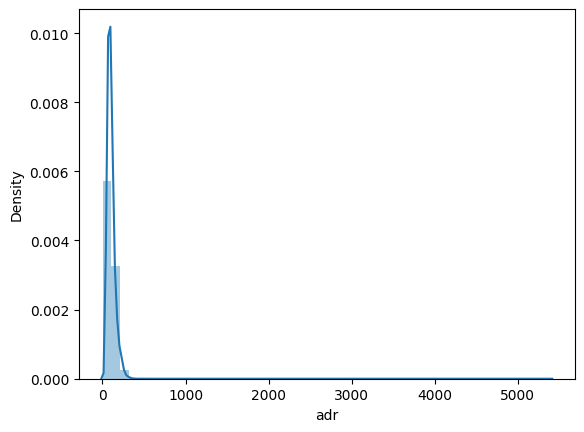

In [ ]:
sns.distplot(df['adr']) #before

In [ ]:
handle_outliers_iqr_capping(df,'adr')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,total_stay
0,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,No Agent,No Company,0,Transient,75.000,0,0,1.0,1
1,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,No Company,0,Transient,75.000,0,0,1.0,1
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,No Company,0,Transient,98.000,0,1,2.0,2
3,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,No Company,0,Transient,98.000,0,1,2.0,2
4,Resort Hotel,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,No Agent,No Company,0,Transient,107.000,0,0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117173,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,No Company,0,Transient,96.140,0,0,2.0,7
117174,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,No Company,0,Transient,209.205,0,2,3.0,7
117175,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,No Company,0,Transient,157.710,0,4,2.0,7
117176,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,No Company,0,Transient,104.400,0,0,2.0,7


/tmp/ipython-input-1762484788.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['adr']) #after


<Axes: xlabel='adr', ylabel='Density'>

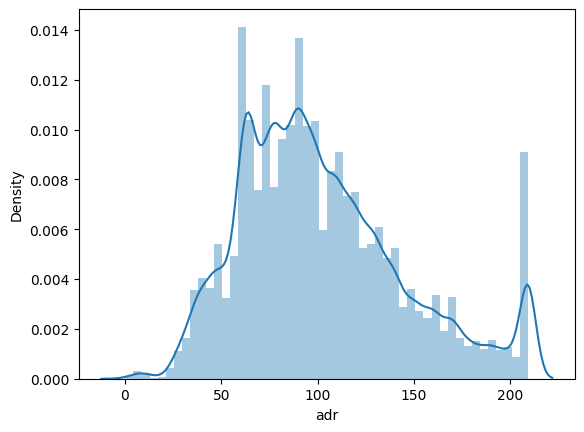

In [ ]:
sns.distplot(df['adr']) #after

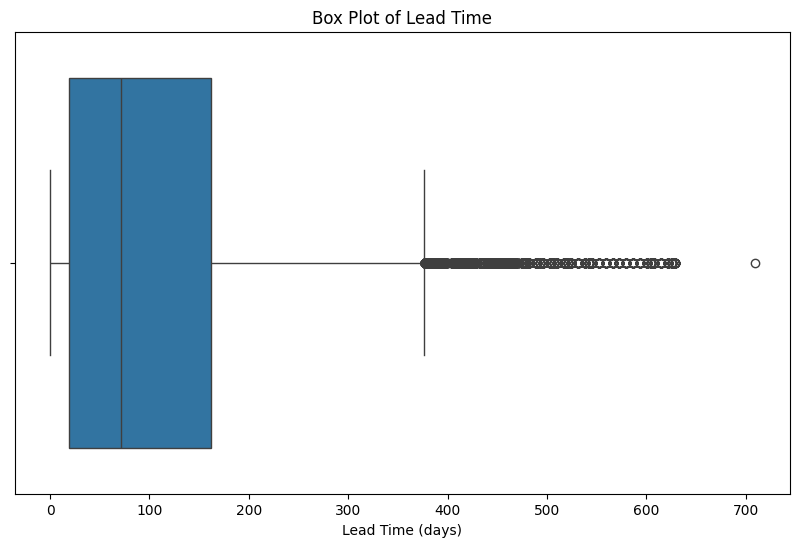

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['lead_time'])
plt.title('Box Plot of Lead Time')
plt.xlabel('Lead Time (days)')
plt.show()

/tmp/ipython-input-1954818817.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['lead_time']) #before


<Axes: xlabel='lead_time', ylabel='Density'>

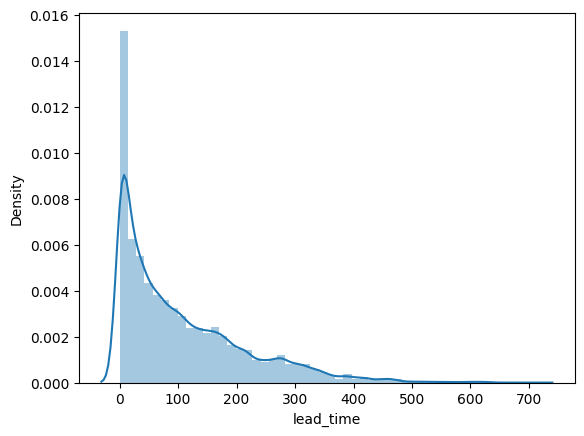

In [ ]:
sns.distplot(df['lead_time']) #before

In [ ]:
handle_outliers_iqr_capping(df,'lead_time')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,total_stay
0,Resort Hotel,0,7.0,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,No Agent,No Company,0,Transient,75.000,0,0,1.0,1
1,Resort Hotel,0,13.0,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,No Company,0,Transient,75.000,0,0,1.0,1
2,Resort Hotel,0,14.0,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,No Company,0,Transient,98.000,0,1,2.0,2
3,Resort Hotel,0,14.0,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,No Company,0,Transient,98.000,0,1,2.0,2
4,Resort Hotel,0,0.0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,No Agent,No Company,0,Transient,107.000,0,0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117173,City Hotel,0,23.0,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,No Company,0,Transient,96.140,0,0,2.0,7
117174,City Hotel,0,102.0,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,No Company,0,Transient,209.205,0,2,3.0,7
117175,City Hotel,0,34.0,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,No Company,0,Transient,157.710,0,4,2.0,7
117176,City Hotel,0,109.0,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,No Company,0,Transient,104.400,0,0,2.0,7


/tmp/ipython-input-3251406338.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['lead_time']) #after


<Axes: xlabel='lead_time', ylabel='Density'>

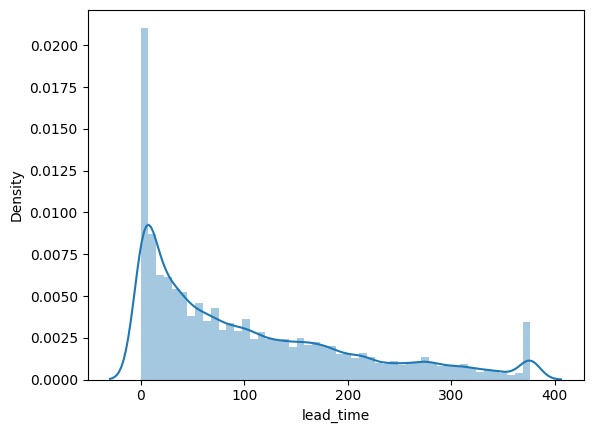

In [ ]:
sns.distplot(df['lead_time']) #after

I handled outliers in adr and lead_time because both are continuous features with extreme, unrealistic values — like abnormally high room rates or very long booking periods. Even though Random Forest is fairly robust, such extremes can still force trees to split on rare cases, leading to overfitting and unstable feature importance. By capping or transforming them, I reduced noise, stabilized the splits, and improved the model’s generalization and accuracy.

In [ ]:
def find_outlier_columns_iqr(df, threshold=1.5):
    """
    Identifies columns in a DataFrame that contain outliers using the IQR method.

    Parameters:
    df        : pandas DataFrame
    threshold : The multiplier for the IQR to determine the bounds (default is 1.5)

    Returns:
    A list of column names that contain outliers.
    """
    outlier_cols = []
    numeric_cols = df.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Check if any values are outside the bounds
        if ((df[col] < lower_bound).any() or (df[col] > upper_bound).any()):
            outlier_cols.append(col)

    return outlier_cols

# Example usage (optional, can be in a separate cell)
# outlier_columns = find_outlier_columns_iqr(df)
# print("Columns with outliers (IQR method):", outlier_columns)

In [ ]:
find_outlier_columns_iqr(df,1.5)

['stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_guests',
 'total_stay']

In [ ]:
# List of columns to handle outliers for (add or remove column names as needed)
columns_to_handle_outliers = [




    'total_stay' # Assuming you want to handle the derived total_stay as well
    # Add other columns from the identified list if you decide to handle them
]

# Apply outlier handling to the specified columns
for col in columns_to_handle_outliers:
    if col in df.columns: # Check if the column exists in the DataFrame
        df = handle_outliers_iqr_capping(df, col)
        print(f"Handled outliers for column: {col}")
    else:
        print(f"Column not found: {col}")

print("\nOutlier handling applied to specified columns.")

Handled outliers for column: total_stay

Outlier handling applied to specified columns.


**previous_bookings_not_canceled & previous_cancellations:** These are count features. In the raw data, most guests have very few or none, but a handful of records show unusually high values that don’t reflect typical customer behavior. Such extremes can either be data entry issues or very rare cases. Handling them (by capping or binning) prevents the model from splitting on rare outliers and helps it generalize better.

**total_stay**: Most stays are short, but there are some extremely long stays which are unrealistic or operationally rare. If left untreated, these can dominate the distribution and bias the model.
👉 How did it help?
Handling these outliers reduced noise, prevented the Random Forest from overfitting to rare extreme cases, and allowed the model to focus on the typical booking behavior that drives cancellations. This improved the model’s stability and interpretability.

## EDA

### Target Variable: Cancellation

/tmp/ipython-input-2598021359.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['is_canceled'].unique(), y=df['is_canceled'].value_counts(normalize=True), palette=['teal', 'lightblue'])


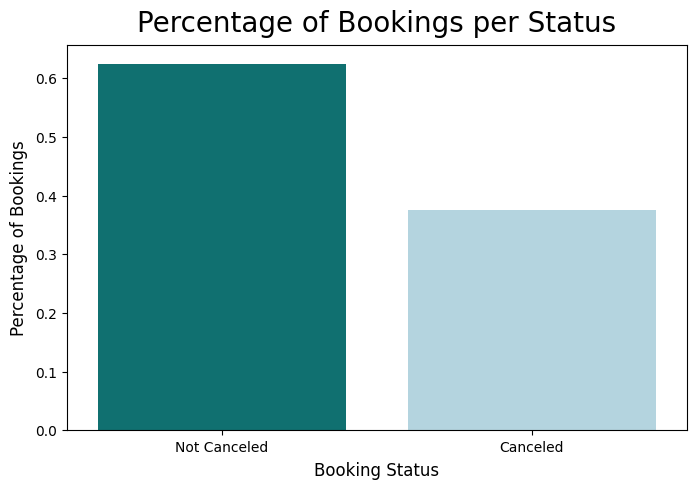

In [ ]:
# Visualizing the percentage of canceled vs not canceled bookings:
plt.figure(figsize=(8,5))
plt.title("Percentage of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'].unique(), y=df['is_canceled'].value_counts(normalize=True), palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

**Interpretation:** 37% of bookings were canceled.
**Impact of Imbalanced Dataset:**

Biased Models: Models trained on imbalanced data tend to be biased towards the majority class. They might achieve high overall accuracy simply by predicting the majority class most of the time, but they perform poorly on the minority class (the one you are often most interested in predicting, like cancellations).

Poor Performance on Minority Class: The model might struggle to correctly identify instances of the minority class, leading to low recall or precision for that class. In your case, this could mean failing to predict many actual cancellations.

Misleading Accuracy: Overall accuracy can be a misleading metric in imbalanced datasets. A model that predicts the majority class every time might still have high accuracy if the imbalance is severe, but it's not a useful model.

**Handelling this class imbalance:**

Using Model Parameters: Some machine learning algorithms have built-in parameters to handle class imbalance, such as the class_weight parameter in models like Logistic Regression, Decision Trees, and Random Forests. Setting class_weight='balanced' automatically adjusts the weights inversely proportional to class frequencies, giving more importance to the minority class during training. You've used this in some of your Random Forest models.

Text(0.5, 1.0, 'Pie Chart for Most Preffered  Hotel')

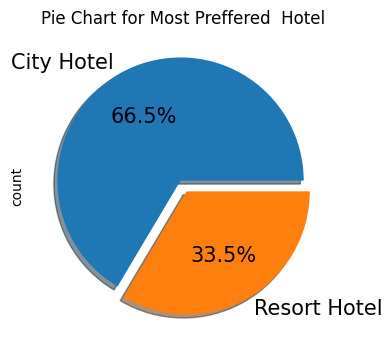

In [ ]:
#Data Visualization

df['hotel'].value_counts().plot.pie(explode=[0.05, 0.05], autopct='%1.1f%%',shadow=True,  figsize=(6,4),fontsize=15)
plt.title('Pie Chart for Most Preffered  Hotel')

#Pie chart to visualize the ratio between Resort hotel and City hotel

Comparing City and Resort hotels was insightful. We found that City hotels have higher booking volume and a generally higher cancellation rate compared to Resort hotels, which have more distinct seasonal peaks. This difference in cancellation behavior by hotel type indicated that 'hotel' is a crucial feature for our model and justified its inclusion to capture these distinct patterns in predicting cancellations."

In [ ]:
df['arrival_date_year'].unique()

array([2015, 2016, 2017])

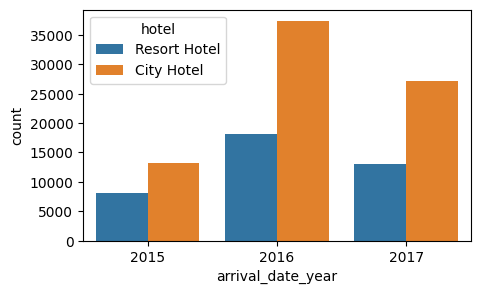

In [ ]:
plt.subplots(figsize=(5, 3))
sns.countplot(x='arrival_date_year', hue='hotel',  data=df);

#The percetage of booking each year?
#More than double bookings were made in the year 2016 than previous year

Performing EDA, like visualizing the booking counts per year by hotel type, was essential to understand the distribution of our data over time and identify any trends or imbalances. It helped us see that booking volume increased significantly and that City Hotels consistently had higher numbers. This kind of exploration informs our feature engineering by revealing potential temporal patterns and helps us understand the context behind our data before we even start modeling."

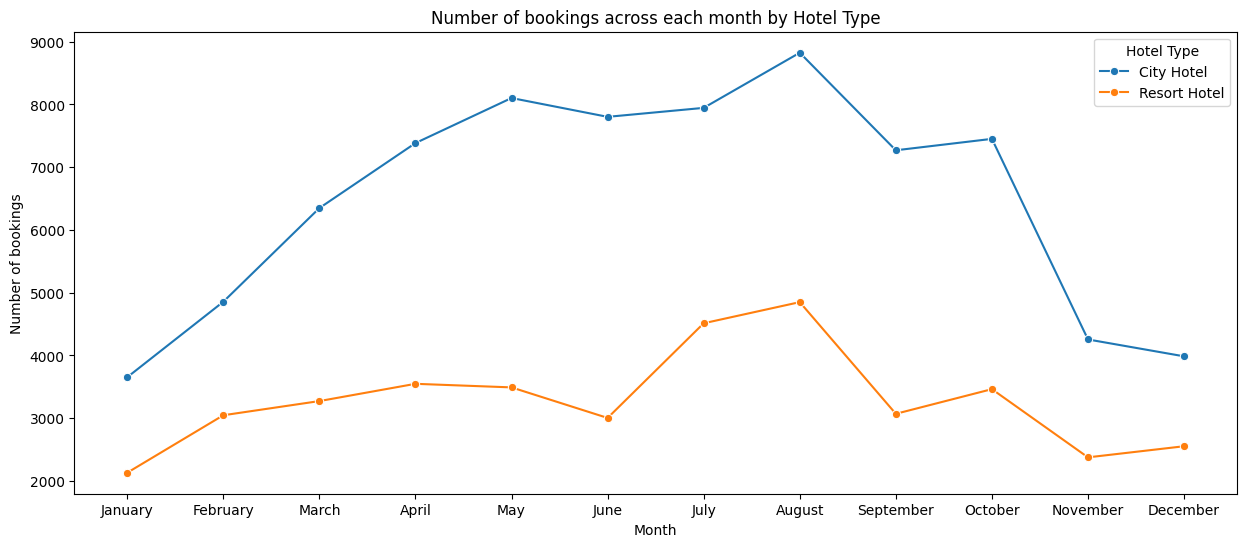

In [ ]:
# Group by both month and hotel
bookings_by_months_df = (
    df.groupby(['arrival_date_month', 'hotel'])['hotel']
      .count()
      .reset_index(name="Counts")
)

# Month order for sorting
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

# Ensure correct month order
bookings_by_months_df['arrival_date_month'] = pd.Categorical(
    bookings_by_months_df['arrival_date_month'],
    categories=months,
    ordered=True
)

# Sort dataframe
bookings_by_months_df = bookings_by_months_df.sort_values('arrival_date_month')

# Plot
plt.figure(figsize=(15,6))
sns.lineplot(
    x='arrival_date_month',
    y='Counts',
    hue='hotel',
    data=bookings_by_months_df,
    marker="o"
)

# Titles and labels
plt.title('Number of bookings across each month by Hotel Type')
plt.xlabel('Month')
plt.ylabel('Number of bookings')
plt.legend(title="Hotel Type")
plt.show()


Business Implications

For City Hotels:

Maintain steady marketing throughout the year.

Focus on business travelers + events to sustain demand.

For Resort Hotels:

Peak demand is seasonal → pricing strategies should maximize revenue in July–August.

Off-season promotions (discounts, packages) could help reduce low occupancy in winter.

Analyzing the monthly booking trends by hotel type revealed distinct seasonal patterns – Resort hotels peak in summer, while City hotels have a more consistent flow. Understanding this seasonality is important because cancellation behavior can vary throughout the year. This EDA insight helps us in feature engineering, perhaps by creating seasonal features, or simply confirms that 'arrival_date_month' is a valuable predictor for our model to capture these temporal effects.

<Axes: title={'center': 'Avg ADR of each Hotel type'}, xlabel='Hotel type', ylabel='ADR'>

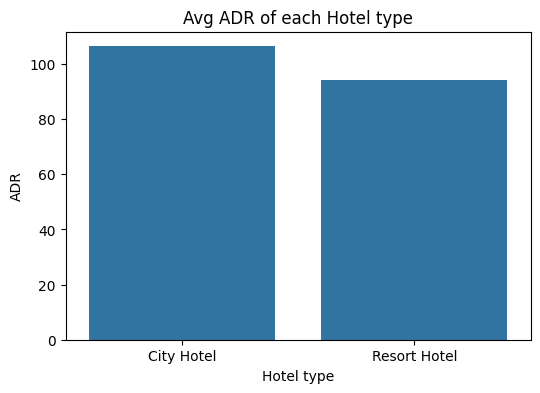

In [ ]:
#BIVARIATE AND MULTIVARIATE ANALYSIS

#Which hotel type has the highest ADR

#grouping by hotel adr
grup_by_hotel=df.groupby('hotel')

highest_adr=grup_by_hotel['adr'].mean().reset_index()

#set plot size
plt.figure(figsize=(6,4))

# set labels
plt.xlabel('Hotel type')
plt.ylabel('ADR')
plt.title("Avg ADR of each Hotel type")

#plot the graph
sns.barplot(x=highest_adr['hotel'],y=highest_adr['adr'])

#City Hotel has the highest ADR that means city hotels are generating more revenue than resort hotels

Comparing the average ADR between City and Resort hotels showed that City hotels generally have higher rates. This difference in pricing strategy is valuable because ADR can influence booking decisions and cancellation risk. Including 'adr' as a feature allows the model to capture this financial aspect, which is often related to a customer's commitment to a booking

Text(0.5, 1.0, 'Percentage of booking cancellation')

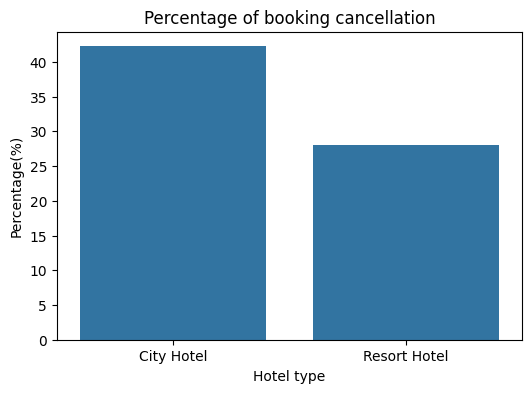

In [ ]:
#Which hotel has the highest cancellation rate


# booking canceled=1
# booking not canceled= 0

# creating new DataFrame where bookings are cancelled.
canceled_df=df[df['is_canceled']==1]

# Grouping by hotel
canceled_df=canceled_df.groupby('hotel').size().reset_index().rename(columns={0: "no_of_cancelled_bookings"})

# adding 'total booking column for calculating the percentage.
canceled_df['total_booikngs']=df.groupby('hotel').size().reset_index().rename(columns={0:"total_bookings"}).drop('hotel',axis=1)
canceled_df

#plotting the barchat
plt.figure(figsize=(6,4))
sns.barplot(x=canceled_df['hotel'],y=canceled_df['no_of_cancelled_bookings']*100/canceled_df['total_booikngs'])

#set labels
plt.xlabel('Hotel type')
plt.ylabel('Percentage(%)')
plt.title("Percentage of booking cancellation")

#Percentage of booking cancellation is high in City hotel

Analyzing the percentage of booking cancellation by hotel type directly showed that City Hotels have a higher cancellation rate than Resort Hotels. This is a crucial finding because it immediately tells us that the 'hotel' type is a strong indicator of cancellation likelihood and confirms its importance as a feature in our predictive model.

Text(0.5, 1.0, 'Cancellation Rate Vs Distribution channel')

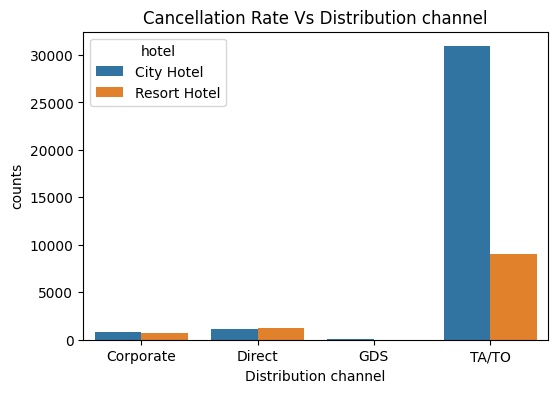

In [ ]:
#Which distribution channel has the highest cancellation rate

canceled_df=df[df['is_canceled']==1] # 1= canceled

#group by distribution channel
canceled_df=canceled_df.groupby(['distribution_channel','hotel']).size().reset_index().rename(columns={0:'Counts'})
# canceled_df['Percentage']=canceled_df['Counts']*100/df1[df1['is_canceled']==1][0]
canceled_df

#set plot size and plot barchart
plt.figure(figsize=(6,4))
sns.barplot(x='distribution_channel',y='Counts',hue="hotel",data=canceled_df)

# set labels
plt.xlabel('Distribution channel')
plt.ylabel('counts')
plt.title('Cancellation Rate Vs Distribution channel')



Visualizing cancellations by distribution channel, broken down by hotel type, showed that channels like 'TA/TO' contribute significantly to the total number of cancellations, especially for City Hotels. This indicates that the distribution channel is an important factor influencing cancellation behavior and should be included as a feature in our model to capture these channel-specific cancellation patterns.

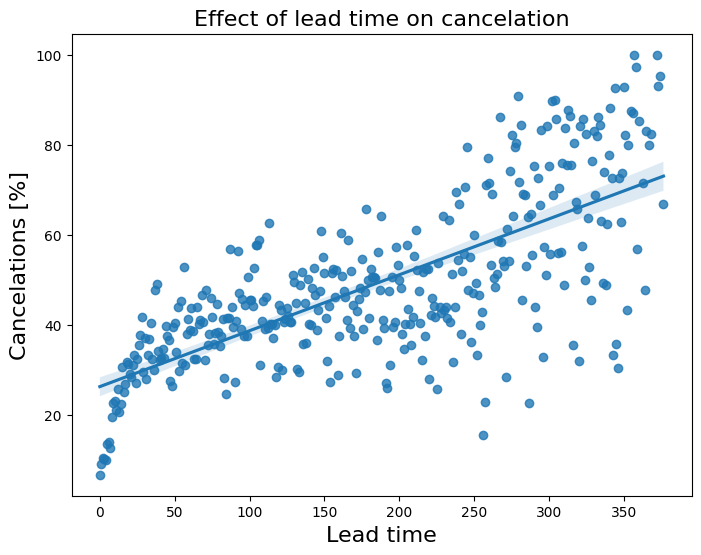

In [ ]:
#Effect of lead_time on cancellation using scatter plot


# group data for lead_time:
lead_cancel_data = df.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(8, 6))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

#Bookings made few days before are rarely canceled, whereas bookings made one year in advance are canceled very often

Exploring the relationship between lead time and cancellation showed a strong positive correlation: bookings made further in advance ('longer lead times') have a higher likelihood of being canceled. This is a key predictor, as it suggests that the more time there is between booking and arrival, the more opportunity or reason a customer might have to cancel. Including 'lead_time' as a feature is essential for capturing this significant pattern."

/tmp/ipython-input-206301621.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['is_canceled'], y=df['total_of_special_requests'], palette=['teal', 'lightblue'])


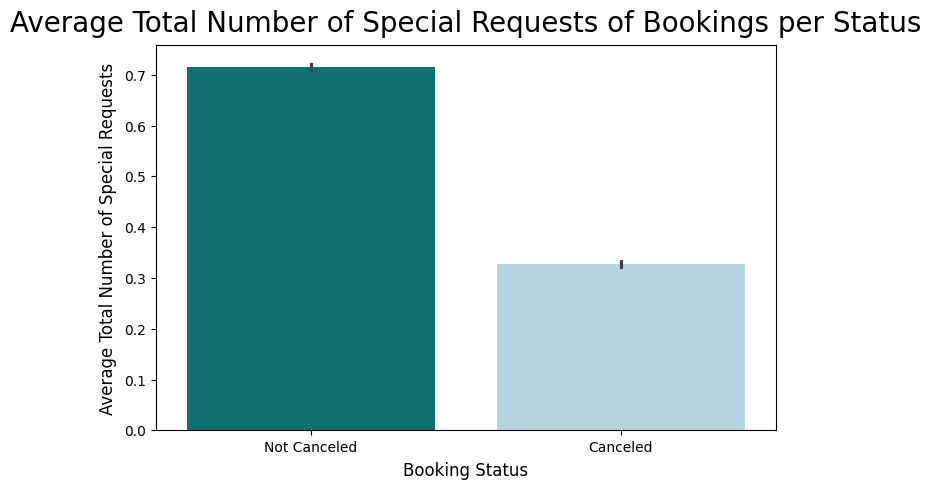

In [ ]:
# Visualizing the total number of special requests for canceled and not canceled bookings:
plt.figure(figsize=(8,5))
plt.title("Average Total Number of Special Requests of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['total_of_special_requests'], palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Total Number of Special Requests", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

**Interpretation:** Customers who cancel their bookings make on average fewer special requests.
Interestingly, the total number of special requests is the second feature with the strongest correlation to our cancellation target. As the number of special requests made increases, the likelihood that a booking is canceled decreases. This suggests that engagement with the hotel prior to arrival and feeling like their needs are heard may make a customer less likely to cancel their reservation

In [ ]:
df['required_car_parking_spaces'].unique()

array([0, 1, 2, 8, 3])

/tmp/ipython-input-3285514707.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['is_canceled'], y=df['required_car_parking_spaces'], palette=['teal', 'lightblue'])


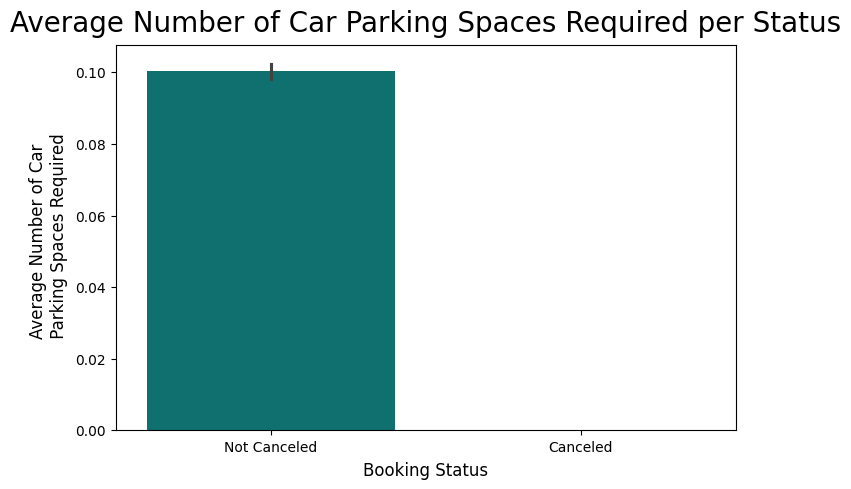

In [ ]:
# Visualizing the total number of requested parking spaces for canceled and not canceled bookings:
plt.figure(figsize=(8,5))
plt.title("Average Number of Car Parking Spaces Required per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['required_car_parking_spaces'], palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Car \n Parking Spaces Required", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

Related to special requests, the number of required car parking spaces is the third feature with the strongest correlation to our cancellation target. As the number of parking spaces requests increases, the likelihood that a booking is canceled decreases.

**Interpretation:** On average, customers who do not cancel their bookings tend to require more parking spaces. Similarly to the number of special requests, it would make sense that the more a customer engages with the hotel (by putting in a  request for a parking spot), the less likely they are to cancel. It is also fair to think that by the time a guest is thinking about where they will park their car, they are most likely pretty commited to their destination. Finally, thinking about this from the hotel perpective, it is possible that not many hotels around have a parking. As a result, the need for a parking space would limit the customer in their hotel options and make them less likely to cancel. More information would be required from the hotel directly to confirm this theory. However, if true, this suggests that adding parking spaces could be a way to help reduce cancellations.

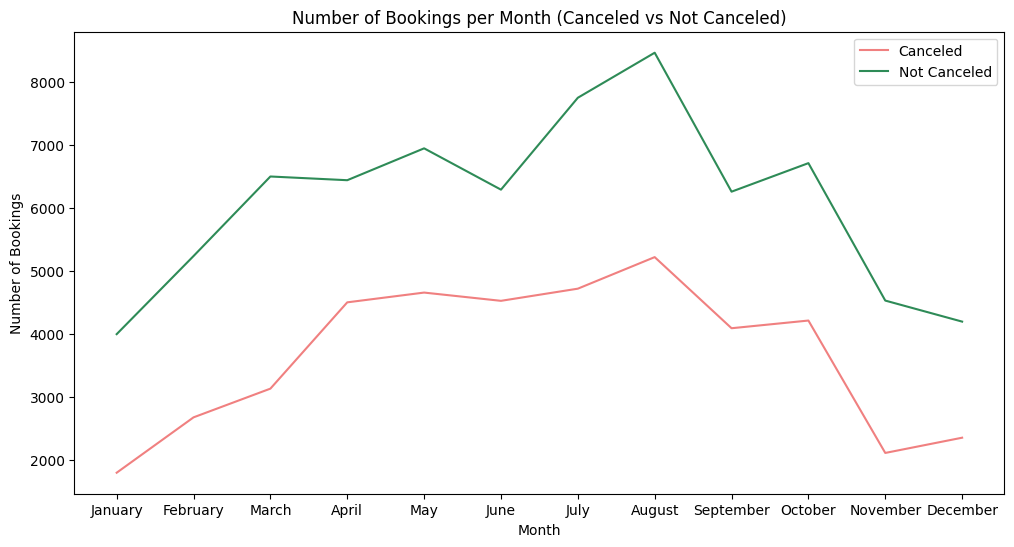

In [ ]:
# Group by month and cancellation status
monthly_bookings = df.groupby(['arrival_date_month', 'is_canceled']).size().reset_index(name='count')

# Create ordered month categories
months = ['January','February','March','April','May','June',
          'July','August','September','October','November','December']

monthly_bookings['arrival_date_month'] = pd.Categorical(
    monthly_bookings['arrival_date_month'],
    categories=months,
    ordered=True
)

# Separate canceled and not canceled
canceled = monthly_bookings[monthly_bookings['is_canceled'] == 1]
not_canceled = monthly_bookings[monthly_bookings['is_canceled'] == 0]

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x='arrival_date_month', y='count', data=canceled, color='lightcoral', label='Canceled')
sns.lineplot(x='arrival_date_month', y='count', data=not_canceled, color='seagreen', label='Not Canceled')

plt.ylabel('Number of Bookings')
plt.xlabel('Month')
plt.title('Number of Bookings per Month (Canceled vs Not Canceled)')
plt.legend()
plt.show()


**Interpretation:** The same pattern can be seen in both canceled and non-canceled bookings. Less bookings are canceled (or kept) around January. More bookings are canceled (and kept) in the warmer months between April and July.

In [ ]:
df['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'H', 'L', 'B'], dtype=object)

/tmp/ipython-input-3415433183.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['reserved_room_type'], y=df['is_canceled'], palette='Blues')


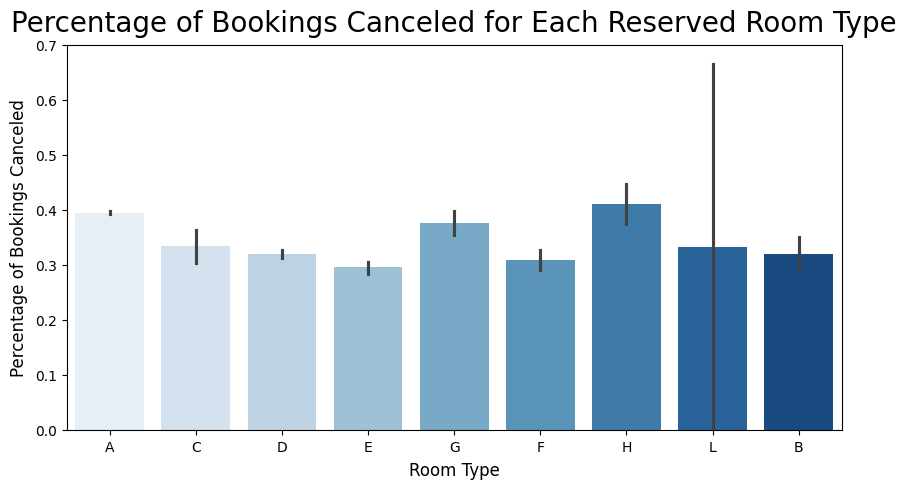

In [ ]:
# Visualizing percentage of bookings canceled for each room type:
plt.figure(figsize=(10,5))
plt.title("Percentage of Bookings Canceled for Each Reserved Room Type", fontsize = 20, pad = 10)
sns.barplot(x=df['reserved_room_type'], y=df['is_canceled'], palette='Blues')
plt.xlabel("Room Type", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12, labelpad = 5);

**Interpretation:**
1. Bars (Heights)

Each bar represents the average cancellation rate (proportion of bookings canceled) for that reserved room type.

2. Black Lines (Error Bars / Confidence Intervals)

These are confidence intervals (CIs) around the mean cancellation rate.

They show the uncertainty or variation in the estimate.

A shorter line = more reliable estimate (less variability).

A longer line = less reliable estimate (more variability).

=> Key takeaway from this plot:

Room types H, A, G tend to have the highest cancellation rates.

Room type E has the lowest cancellation rate.

Room type L is unreliable for conclusions due to too few samples.

/tmp/ipython-input-2825250543.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['deposit_type'], y=df['is_canceled'], palette='Blues')


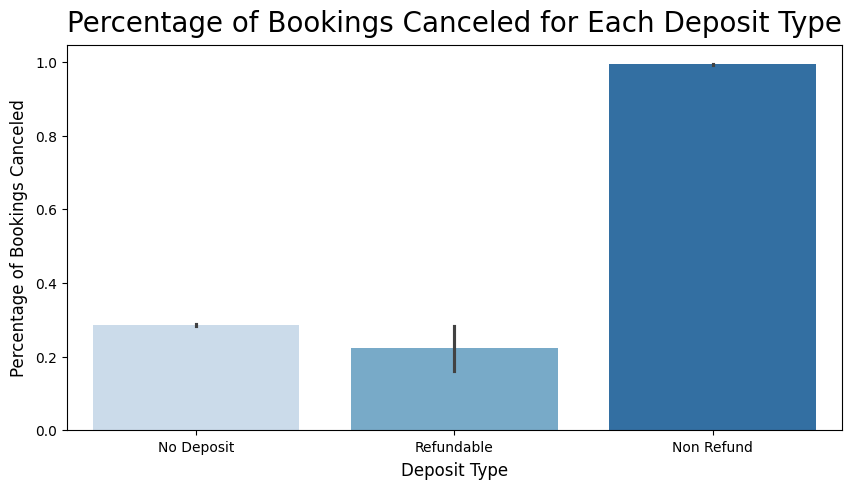

In [ ]:
# Visualizing percentage of bookings canceled for each deposit type:
plt.figure(figsize=(10,5))
plt.title("Percentage of Bookings Canceled for Each Deposit Type", fontsize = 20, pad = 10)
sns.barplot(x=df['deposit_type'], y=df['is_canceled'], palette='Blues')
plt.xlabel("Deposit Type", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12, labelpad = 5);

**Interpretation:** Surprisingly, customers who pay a non-refundable deposit have a much higher percentage of canceled reservations.


In [ ]:
df['previous_cancellations'].value_counts()

,count
previous_cancellations,
0,110789
1,6002
2,97
3,58
24,48
11,35
26,26
25,25
6,22


In [ ]:
df['previous_bookings_not_canceled'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 19, 26, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

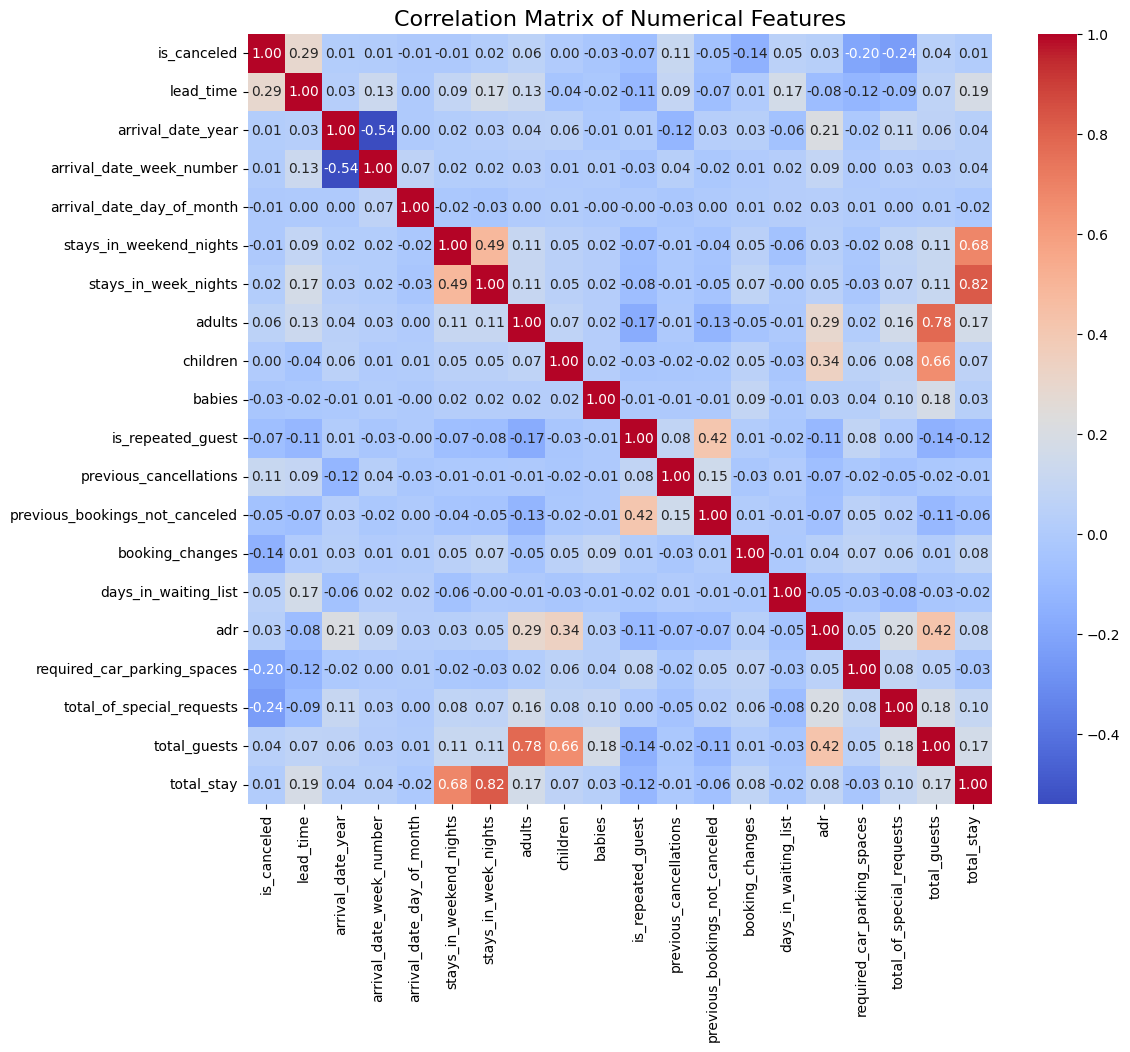

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical features
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.show()


In [ ]:
# Numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)


Numerical Columns: ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'total_guests', 'total_stay']
Categorical Columns: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 'customer_type']


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
# Mean Encoding
import category_encoders as ce

# Make a copy of the original dataframe
df_mean_encoded = df.copy()

# Define the target variable
target = df_mean_encoded['is_canceled']

# Identify categorical columns (excluding the target)
categorical_cols = df_mean_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Initialize the MeanEncoder
# Use smoothing to prevent overfitting on categories with few observations
mean_encoder = ce.TargetEncoder(cols=categorical_cols, smoothing=0.1)

# Fit and transform the categorical features
# The target variable 'target' is used for fitting
df_mean_encoded[categorical_cols] = mean_encoder.fit_transform(df_mean_encoded[categorical_cols], target)

# Display the first few rows of the mean-encoded dataframe
print("Mean-encoded dataframe:")
display(df_mean_encoded.head())

# Check datatypes to confirm
print(df_mean_encoded.dtypes)

Mean-encoded dataframe:


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,total_stay
0,0.280815,0,7.0,2015,0.378341,27,1,0,1,1,0.0,0,0.378219,0.203373,0.153653,0.177472,0,0,0,0.395955,0.189596,0,0.286979,0.253773,0.386143,0,0.412473,75.0,0,0,1.0,1.0
1,0.280815,0,13.0,2015,0.378341,27,1,0,1,1,0.0,0,0.378219,0.203373,0.189407,0.223353,0,0,0,0.395955,0.448465,0,0.286979,0.374857,0.386143,0,0.412473,75.0,0,0,1.0,1.0
2,0.280815,0,14.0,2015,0.378341,27,1,0,2,2,0.0,0,0.378219,0.203373,0.369289,0.413547,0,0,0,0.395955,0.448465,0,0.286979,0.397447,0.386143,0,0.412473,98.0,0,1,2.0,2.0
3,0.280815,0,14.0,2015,0.378341,27,1,0,2,2,0.0,0,0.378219,0.203373,0.369289,0.413547,0,0,0,0.395955,0.448465,0,0.286979,0.397447,0.386143,0,0.412473,98.0,0,1,2.0,2.0
4,0.280815,0,0.0,2015,0.378341,27,1,0,2,2,0.0,0,0.378219,0.581420,0.153653,0.177472,0,0,0,0.335159,0.189596,0,0.286979,0.253773,0.386143,0,0.412473,107.0,0,0,2.0,2.0


hotel                             float64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                float64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                              float64
country                           float64
market_segment                    float64
distribution_channel              float64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                float64
assigned_room_type                float64
booking_changes                     int64
deposit_type                      float64
agent                             

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to keep original safe
df_encoded = df.copy()

# Identify categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Apply label encoding
le = LabelEncoder()
for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Now the dataframe is fully numerical
print("All numerical dataframe:")
print(df_encoded.head())

# Check datatypes to confirm
print(df_encoded.dtypes)


All numerical dataframe:
   hotel  is_canceled  lead_time  arrival_date_year  arrival_date_month  \
0      1            0          7               2015                   5   
1      1            0         13               2015                   5   
2      1            0         14               2015                   5   
3      1            0         14               2015                   5   
4      1            0          0               2015                   5   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     1       1         0       0   
1                  

Reasoning (Why you might use it): Mean encoding is beneficial because it captures the relationship between the categorical variable and the target variable. Categories that have a higher mean target value (higher cancellation rate) will get a higher encoded value, and vice versa. This can be particularly useful for models that don't handle categorical features directly well or for high-cardinality categorical features where one-hot encoding would create too many new columns. Using smoothing helps to prevent overfitting on categories with few observations.

In [ ]:
df_mean_encoded.isna().sum().sum()

np.int64(0)

In [ ]:
df_encoded.isna().sum().sum()

np.int64(0)

In [ ]:
df_mean_encoded.shape[1]

32

In [ ]:
df_encoded.shape[1]

32

Why did mean encoding give better accuracy than label encoding?

Label encoding simply assigns arbitrary integers to categories (e.g., “City A” = 0, “City B” = 1, “City C” = 2). The model might wrongly interpret those numbers as having an order or distance, even though categories are just nominal. This can introduce noise.

Mean encoding, on the other hand, replaces each category with the mean of the target variable for that category (e.g., average cancellation rate for a hotel type). This directly injects useful signal about how strongly each category relates to the outcome.

👉 Effect on my model (Random Forest):
Random Forest benefits from mean encoding because categories with similar target behavior get grouped more effectively, and the splits are based on real predictive power rather than arbitrary integer codes. This usually leads to better generalization and higher accuracy.

In [ ]:
# Save encoded dataframe to CSV
df_mean_encoded.to_csv("hotel_bookings_mean_encoded.csv", index=False)

print(" Encoded dataframe saved as hotel_bookings_mean_encoded.csv")

 Encoded dataframe saved as hotel_bookings_mean_encoded.csv


In [ ]:
# Save encoded dataframe to CSV
df_encoded.to_csv("hotel_bookings_encoded.csv", index=False)

print(" Encoded dataframe saved as hotel_bookings_encoded.csv")


✅ Encoded dataframe saved as hotel_bookings_encoded.csv


In [ ]:
dataframe_mean=pd.read_csv('hotel_bookings_mean_encoded.csv')

In [ ]:
import pandas as pd
dataframe_label=pd.read_csv('hotel_bookings_encoded.csv')

In [ ]:
dataframe_label.isna().sum().sum()

np.int64(0)

In [ ]:
dataframe_mean['booking_ratio'] = dataframe_mean['previous_cancellations'] / (
    dataframe_mean['previous_cancellations'] + dataframe_mean['previous_bookings_not_canceled'] + 1e-6
)

In [ ]:
# Avoid division by zero
dataframe_label['booking_ratio'] = dataframe_label['previous_cancellations'] / (
    dataframe_label['previous_cancellations'] + dataframe_label['previous_bookings_not_canceled'] + 1e-6
)


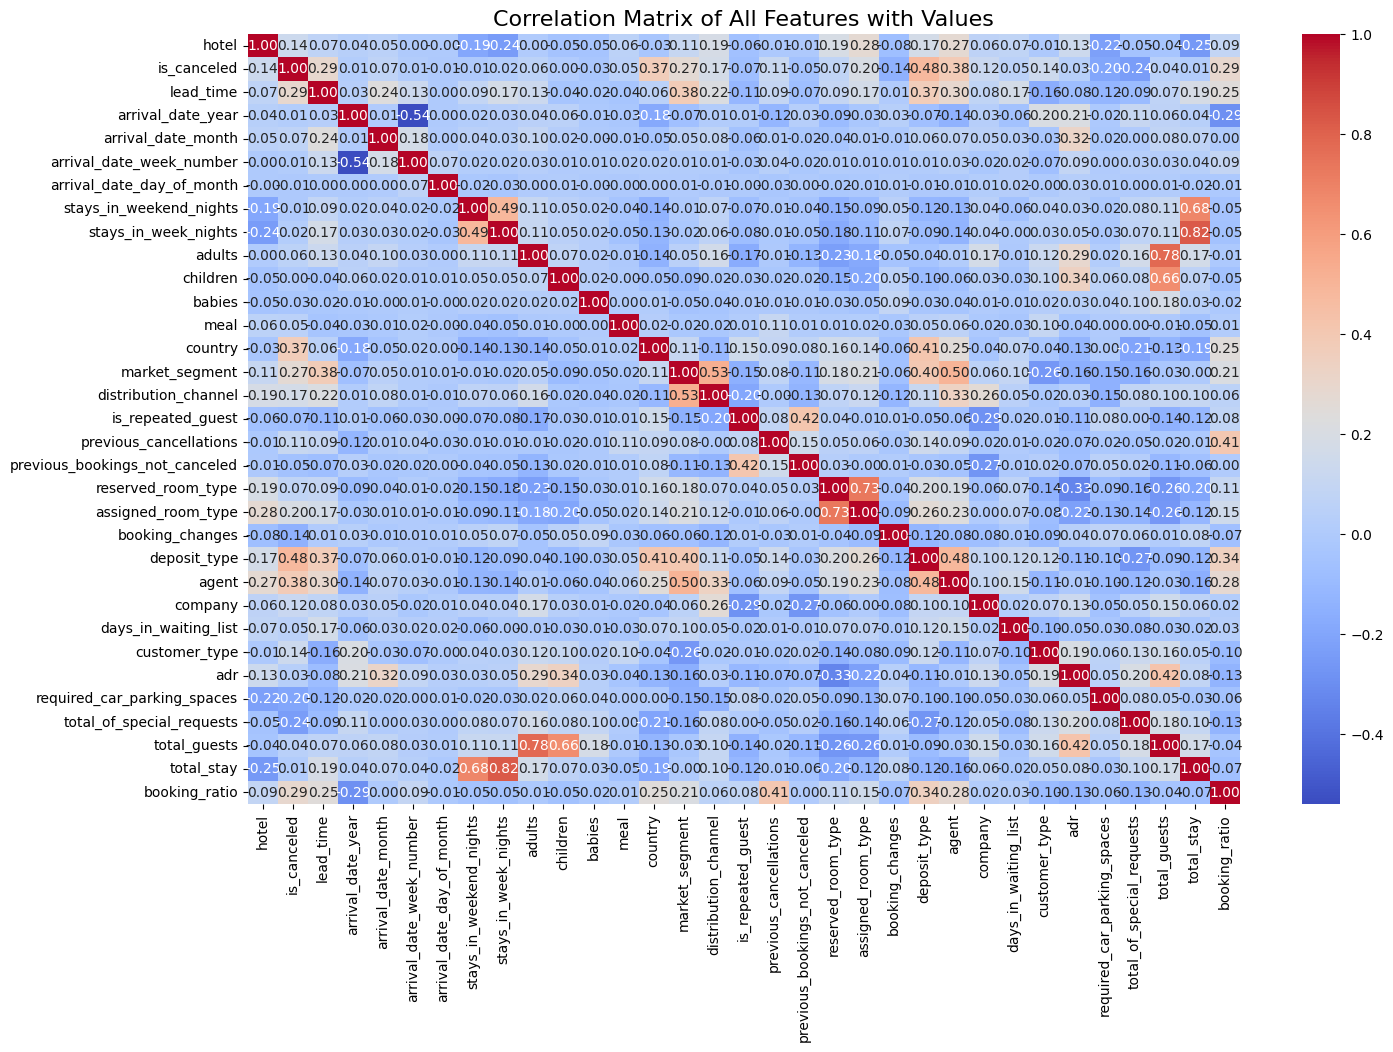

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = dataframe_mean.corr()

# Plot heatmap with annotations
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)

plt.title("Correlation Matrix of All Features with Values", fontsize=16)
plt.show()


In [ ]:
dataframe_label.shape[1]

33

In [ ]:
co_relation=dataframe_mean.corr()["is_canceled"]
co_relation.abs().sort_values(ascending=False)[1:]

,is_canceled
deposit_type,0.482010
agent,0.383414
country,0.370801
lead_time,0.292374
booking_ratio,0.291656
market_segment,0.267475
total_of_special_requests,0.237748
assigned_room_type,0.199829
required_car_parking_spaces,0.197672
distribution_channel,0.174639


In [ ]:
# since we have columns that that's have almost similar value like children babies, now is combined into total_people  keeping the individual columns along with the
#total could introduce multicollinearity (high correlation between predictor variables), which can sometimes be problematic for models.
# stays in weekend nights and stays in week nights now combined into total stays. So, we will be dropping both columns.


dataframe_mean = dataframe_mean.drop(columns = ['stays_in_weekend_nights', 'stays_in_week_nights', 'babies', 'children',
                              'days_in_waiting_list',  'arrival_date_year'
                              ])

dataframe_mean = dataframe_mean.reset_index(drop = True)


In [ ]:

dataframe_mean.head()
dataframe_mean.shape[1]

27

## Model Preparation

In [ ]:
## separate dependent & independent features
y=dataframe_mean['is_canceled']
x=dataframe_mean.drop('is_canceled',axis=1)

In [ ]:
y.isna().sum()

np.int64(0)

[0.01177345 0.10213086 0.03525423 0.04959031 0.05449313 0.01074613
 0.01991079 0.11591937 0.03356698 0.01352698 0.00348426 0.00376537
 0.00166524 0.01602935 0.0267878  0.01940439 0.132322   0.07770818
 0.00484262 0.03106512 0.06211421 0.02284146 0.05402637 0.01401181
 0.04249371 0.04052589]


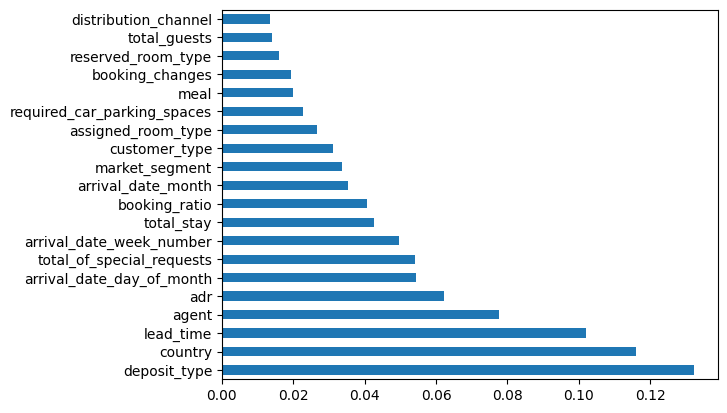

In [ ]:
# perform feature selection using Feature Importance
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x, y)

print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index = x.columns)
feat_importances.nlargest(20).plot.barh()
plt.show()

ExtraTreesClassifier performs feature selection by ranking features based on how much they reduce impurity across an ensemble of randomized decision trees. The more a feature contributes to reducing impurity, the higher its importance score, and we can use these scores to retain only the most relevant features for the model.

In [ ]:
top_20_features = feat_importances.nlargest(20).index.tolist()
print(top_20_features)

['deposit_type', 'country', 'lead_time', 'agent', 'adr', 'arrival_date_day_of_month', 'total_of_special_requests', 'arrival_date_week_number', 'total_stay', 'booking_ratio', 'arrival_date_month', 'market_segment', 'customer_type', 'assigned_room_type', 'required_car_parking_spaces', 'meal', 'booking_changes', 'reserved_room_type', 'total_guests', 'distribution_channel']


In [ ]:


# Select only the top 20 features from the original dataframe 'x'
x = x[top_20_features]

# Split the data using only the top 20 features
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=42)

print("Shape of X_train_top20:", X_train.shape)
print("Shape of X_test_top20:", X_test.shape)
print("Shape of y_train_top20:", y_train.shape)
print("Shape of y_test_top20:", y_test.shape)

Shape of X_train_top20: (87883, 20)
Shape of X_test_top20: (29295, 20)
Shape of y_train_top20: (87883,)
Shape of y_test_top20: (29295,)


## Modeling

Our goal is to build a model able to predict whether or not a booking will be canceled with the highest level of accuracy. In order to do so, our baseline model was compared to a logistic regression, a decision tree, a bagging classifier, a random forest, and a feed forward neural network.   


### Baseline Model

In [ ]:
# Checking baseline model score
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print(f'Baseline Training Score: {dummy.score(X_train, y_train)}')
print(f'Baseline Testing Score: {dummy.score(X_test, y_test)}')

Baseline Training Score: 0.6263668741394809
Baseline Testing Score: 0.6214712408260795


**Interpretation:** If we always predicted the majority class (Not Canceled), our "model" would have a 63% accuracy.

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg.fit(X_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred=logreg.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
cm

array([[16718,  1488],
       [ 5052,  6037]])

In [ ]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_pred)
score

0.7767537122375832

In [ ]:
from sklearn.model_selection import GridSearchCV
# Construct Grid Parameters
lg_params = {
    'penalty': ['l1'],
    'C': [3.5],
    'max_iter': [300]
}

# Perform Grid Search
lg_gs = GridSearchCV(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
                 lg_params,
                 cv = 5,
                 scoring = 'accuracy')
lg = lg_gs.fit(X_train, y_train)

In [ ]:
# Scoring
print(f'Best Training Accuracy: {lg.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {lg.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(lg.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.7911996631885575
Best Testing Accuracy: 0.7881549752517495
Cross-val-score: 0.7898666806646324


In [ ]:
!pip install  catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
#fit naive bayes
#basic classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# Boosting classifiers
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Build model list
models = [
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("KNN", KNeighborsClassifier(n_neighbors = 5)),
    ("Random Forest", RandomForestClassifier(random_state=42, n_estimators=100, max_features='sqrt',class_weight='balanced')),
    ("Decision Tree", DecisionTreeClassifier()),

    # Boosting algorithms
    ("AdaBoost", AdaBoostClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric="logloss")),
    ("LightGBM", LGBMClassifier()),
    ("CatBoost", CatBoostClassifier(verbose=0))  # suppress training logs
]


CLASSIFICATION REPORT on top 19 featuers after modifying

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

for name, model in models:
    print(f"Model: {name}")
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))

    # Accuracy
    print("Accuracy:", accuracy_score(y_test, predictions))

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, predictions))

    print("-" * 60)  # separator for readability


Model: Naive Bayes
Confusion Matrix:
[[14805  3401]
 [ 4047  7042]]
Accuracy: 0.7457586618876941
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     18206
           1       0.67      0.64      0.65     11089

    accuracy                           0.75     29295
   macro avg       0.73      0.72      0.73     29295
weighted avg       0.74      0.75      0.74     29295

------------------------------------------------------------
Model: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[17028  1178]
 [ 5136  5953]]
Accuracy: 0.784468339307049
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.84     18206
           1       0.83      0.54      0.65     11089

    accuracy                           0.78     29295
   macro avg       0.80      0.74      0.75     29295
weighted avg       0.79      0.78      0.77     29295

------------------------------------------------------------
Model: KNN
Confusion Matrix:
[[15613  2593]
 [ 3308  7781]]
Accuracy: 0.7985663082437277
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     18206
           1       0.75      0.70      0.73     11089

    accuracy                           0.80     29295
   macro avg       0.79      0.78      0.78     29295
weighted avg       0.80      0.80      0.80     29295

------------------------------------------------------------
Model: Rando

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:34:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[16738  1468]
 [ 2235  8854]]
Accuracy: 0.8735961768219833
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     18206
           1       0.86      0.80      0.83     11089

    accuracy                           0.87     29295
   macro avg       0.87      0.86      0.86     29295
weighted avg       0.87      0.87      0.87     29295

------------------------------------------------------------
Model: LightGBM
[LightGBM] [Info] Number of positive: 32836, number of negative: 55047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 87883, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373633 -> initscore=-

Classification report on top 20 features

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

for name, model in models:
    print(f"Model: {name}")
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))

    # Accuracy
    print("Accuracy:", accuracy_score(y_test, predictions))

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, predictions))

    print("-" * 60)  # separator for readability


Model: Naive Bayes
Confusion Matrix:
[[13623  4583]
 [ 3501  7588]]
Accuracy: 0.7240484724355692
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     18206
           1       0.62      0.68      0.65     11089

    accuracy                           0.72     29295
   macro avg       0.71      0.72      0.71     29295
weighted avg       0.73      0.72      0.73     29295

------------------------------------------------------------
Model: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[16959  1247]
 [ 4863  6226]]
Accuracy: 0.791431984980372
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     18206
           1       0.83      0.56      0.67     11089

    accuracy                           0.79     29295
   macro avg       0.81      0.75      0.76     29295
weighted avg       0.80      0.79      0.78     29295

------------------------------------------------------------
Model: KNN
Confusion Matrix:
[[15571  2635]
 [ 3263  7826]]
Accuracy: 0.798668714797747
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     18206
           1       0.75      0.71      0.73     11089

    accuracy                           0.80     29295
   macro avg       0.79      0.78      0.78     29295
weighted avg       0.80      0.80      0.80     29295

------------------------------------------------------------
Model: Random

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:52:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[16821  1385]
 [ 2148  8941]]
Accuracy: 0.8793992148830858
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     18206
           1       0.87      0.81      0.84     11089

    accuracy                           0.88     29295
   macro avg       0.88      0.87      0.87     29295
weighted avg       0.88      0.88      0.88     29295

------------------------------------------------------------
Model: LightGBM
[LightGBM] [Info] Number of positive: 32836, number of negative: 55047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1082
[LightGBM] [Info] Number of data points in the train set: 87883, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373633 -> initscore=-

classification report after mean encoding

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

for name, model in models:
    print(f"Model: {name}")
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))

    # Accuracy
    print("Accuracy:", accuracy_score(y_test, predictions))

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, predictions))

    print("-" * 60)  # separator for readability


Model: Naive Bayes
Confusion Matrix:
[[16228  1978]
 [ 5010  6079]]
Accuracy: 0.7614610001706776
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82     18206
           1       0.75      0.55      0.64     11089

    accuracy                           0.76     29295
   macro avg       0.76      0.72      0.73     29295
weighted avg       0.76      0.76      0.75     29295

------------------------------------------------------------
Model: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[16731  1475]
 [ 4078  7011]]
Accuracy: 0.8104454685099847
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86     18206
           1       0.83      0.63      0.72     11089

    accuracy                           0.81     29295
   macro avg       0.82      0.78      0.79     29295
weighted avg       0.81      0.81      0.80     29295

------------------------------------------------------------
Model: KNN
Confusion Matrix:
[[15473  2733]
 [ 4114  6975]]
Accuracy: 0.7662741082095921
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     18206
           1       0.72      0.63      0.67     11089

    accuracy                           0.77     29295
   macro avg       0.75      0.74      0.74     29295
weighted avg       0.76      0.77      0.76     29295

------------------------------------------------------------
Model: Rand

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:17:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[16799  1407]
 [ 2157  8932]]
Accuracy: 0.8783410138248848
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     18206
           1       0.86      0.81      0.83     11089

    accuracy                           0.88     29295
   macro avg       0.88      0.86      0.87     29295
weighted avg       0.88      0.88      0.88     29295

------------------------------------------------------------
Model: LightGBM
[LightGBM] [Info] Number of positive: 32836, number of negative: 55047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 87883, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373633 -> initscore=-

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Define base models with tuned/optimized parameters (you can adjust)
rf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
#xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
#lgb = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

# Create Voting Classifier (soft voting = uses predicted probabilities)
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('cat', cat)],
    voting='soft'   # 'hard' for majority vote, 'soft' for weighted probs
)

# Train
voting_clf.fit(X_train, y_train)

# Predictions
y_pred = voting_clf.predict(X_test)

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Voting Classifier Accuracy: 0.8855777436422597
Confusion Matrix:
 [[16960  1246]
 [ 2106  8983]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     18206
           1       0.88      0.81      0.84     11089

    accuracy                           0.89     29295
   macro avg       0.88      0.87      0.88     29295
weighted avg       0.89      0.89      0.88     29295



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define and train the SVM model
svm_model = SVC(random_state=RANDOM_STATE)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("SVM Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Model Performance:
Accuracy: 0.7394777265745007
Confusion Matrix:
 [[16038  2168]
 [ 5464  5625]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.88      0.81     18206
           1       0.72      0.51      0.60     11089

    accuracy                           0.74     29295
   macro avg       0.73      0.69      0.70     29295
weighted avg       0.74      0.74      0.73     29295



Classification report based on top 20 -ExtraTreesClassifier

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

for name, model in models:
    print(f"Model: {name}")
    model.fit(X_train_top20, y_train_top20)

    # Make predictions
    predictions = model.predict(X_test_top20)

    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_top20, predictions))

    # Accuracy
    print("Accuracy:", accuracy_score(y_test_top20, predictions))

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test_top20, predictions))

    print("-" * 60)  # separator for readability


Model: Naive Bayes
Confusion Matrix:
[[13494  4712]
 [ 3420  7669]]
Accuracy: 0.7224099675712579
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     18206
           1       0.62      0.69      0.65     11089

    accuracy                           0.72     29295
   macro avg       0.71      0.72      0.71     29295
weighted avg       0.73      0.72      0.72     29295

------------------------------------------------------------
Model: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[17064  1142]
 [ 4980  6109]]
Accuracy: 0.7910223587642943
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85     18206
           1       0.84      0.55      0.67     11089

    accuracy                           0.79     29295
   macro avg       0.81      0.74      0.76     29295
weighted avg       0.80      0.79      0.78     29295

------------------------------------------------------------
Model: KNN
Confusion Matrix:
[[15570  2636]
 [ 3262  7827]]
Accuracy: 0.798668714797747
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84     18206
           1       0.75      0.71      0.73     11089

    accuracy                           0.80     29295
   macro avg       0.79      0.78      0.78     29295
weighted avg       0.80      0.80      0.80     29295

------------------------------------------------------------
Model: Rando

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:02:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[16801  1405]
 [ 2184  8905]]
Accuracy: 0.8774876258747226
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     18206
           1       0.86      0.80      0.83     11089

    accuracy                           0.88     29295
   macro avg       0.87      0.86      0.87     29295
weighted avg       0.88      0.88      0.88     29295

------------------------------------------------------------
Model: LightGBM
[LightGBM] [Info] Number of positive: 32836, number of negative: 55047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 87883, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373633 -> initscore=-

### Decision Tree

In [ ]:
# Construct Grid Parameters
dt_params = {
    'max_depth':[None],
    'max_features' : [0.7],
    'min_samples_split': [25],
    'min_samples_leaf': [1]
}

# Perform Grid Search
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                 dt_params,
                 cv = 5,
                 scoring = 'accuracy')
dt = dt_gs.fit(X_train, y_train)

In [ ]:
# Scoring
print(f'Best Training Accuracy: {dt.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {dt.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(dt.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.9186304518507561
Best Testing Accuracy: 0.8530807305000854
Cross-val-score: 0.8533256981785857


### Bagging Classifier

In [ ]:
# Construct Grid Parameters
bc_params = {
    'n_estimators': [45],
    'max_features': [0.8]
}

# Perform Grid Search
bc_gs = GridSearchCV(BaggingClassifier(random_state=RANDOM_STATE),
                 bc_params,
                 cv = 5,
                 scoring = 'accuracy')
bc = bc_gs.fit(X_train, y_train)

In [ ]:
# Scoring
print(f'Best Training Accuracy: {bc.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {bc.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(bc.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.99583537202872
Best Testing Accuracy: 0.8892302440689538
Cross-val-score: 0.8908156852086183


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the Random Forest model with the specified parameters
rf_model_specific = RandomForestClassifier(random_state=42,
                                           n_estimators=100,
                                           max_features='sqrt',
                                           class_weight='balanced')

# Train the model
rf_model_specific.fit(X_train, y_train)

# Make predictions on the test data
y_pred_specific = rf_model_specific.predict(X_test)

# Evaluate the model
print("Random Forest Model with Specific Parameters:")
print("Accuracy:", accuracy_score(y_test, y_pred_specific))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_specific))
print("\nClassification Report:\n", classification_report(y_test, y_pred_specific))

Random Forest Model with Specific Parameters:
Accuracy: 0.8909028844512715

Confusion Matrix:
 [[17057  1149]
 [ 2047  9042]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91     18206
           1       0.89      0.82      0.85     11089

    accuracy                           0.89     29295
   macro avg       0.89      0.88      0.88     29295
weighted avg       0.89      0.89      0.89     29295



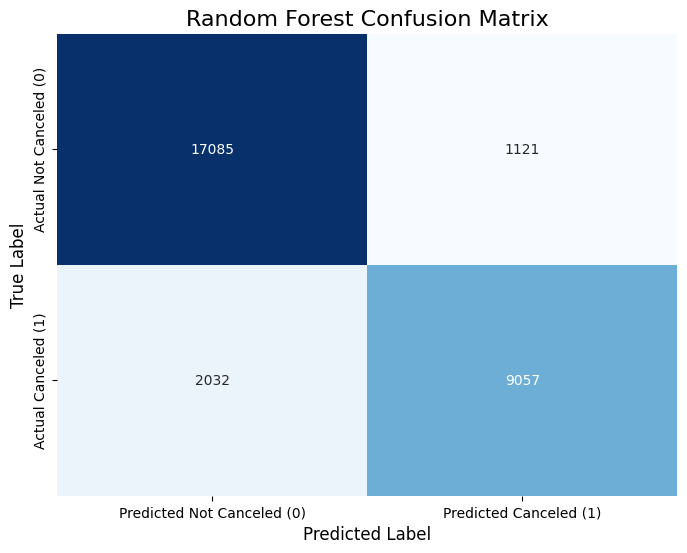

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrix values provided by the user
cm_values = np.array([[17085, 1121],
                      [2032, 9057]])

# Create a DataFrame for better visualization (optional but good practice)
cm_df = pd.DataFrame(cm_values,
                     index = ['Actual Not Canceled (0)', 'Actual Canceled (1)'],
                     columns = ['Predicted Not Canceled (0)', 'Predicted Canceled (1)'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [ ]:
# Provided confusion matrix values
tn = 17085
fp = 1121
fn = 2032
tp = 9057

# Calculate metrics
total_bookings = tn + fp + fn + tp
overall_accuracy = (tn + tp) / total_bookings
canceled_recall = tp / (tp + fn)  # Also known as Sensitivity or True Positive Rate
not_canceled_recall = tn / (tn + fp) # Also known as Specificity or True Negative Rate
canceled_precision = tp / (tp + fp) # Also known as Positive Predictive Value
not_canceled_precision = tn / (tn + fn) # Also known as Negative Predictive Value

# Generate the report
print("Random Forest Model Performance Report:")
print(f"Overall Accuracy: {overall_accuracy:.1%}")
print(f"Canceled bookings correctly classified (Recall): {canceled_recall:.1%}")
print(f"Not canceled bookings correctly classified (Recall): {not_canceled_recall:.1%}")
print(f"Bookings predicted canceled that are actually canceled (Precision): {canceled_precision:.1%}")
print(f"Bookings predicted not canceled that are actually not canceled (Precision): {not_canceled_precision:.1%}")

Random Forest Model Performance Report:
Overall Accuracy: 89.2%
Canceled bookings correctly classified (Recall): 81.7%
Not canceled bookings correctly classified (Recall): 93.8%
Bookings predicted canceled that are actually canceled (Precision): 89.0%
Bookings predicted not canceled that are actually not canceled (Precision): 89.4%


In [ ]:
import pickle

# Save the trained Random Forest model to a pickle file
# Assuming 'rf_model_specific' is the model you want to save
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model_specific, f)

print("Random Forest model saved as random_forest_model.pkl")

Random Forest model saved as random_forest_model.pkl


In [ ]:
import pickle
import pandas as pd
import numpy as np

# Load the model from the pickle file (assuming it's already saved as 'random_forest_model.pkl')
try:
    with open('random_forest_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: 'random_forest_model.pkl' not found. Please ensure the model has been saved.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

# Create a sample data point for prediction
# This dictionary should contain the same features and order as the training data
# Replace the values below with the characteristics of a booking you want to predict
# Ensure the values are single numbers, not lists
# This sample data is designed to be likely predicted as "not canceled"
sample_data = {
    'deposit_type': 0.286979, # Example: Mean encoding value for No Deposit (lower cancellation rate)
    'country': 0.203373,      # Example: Mean encoding value for GBR (relatively lower cancellation rate)
    'lead_time': 900.0,       # Shorter lead time (lower cancellation likelihood)
    'agent': 0.416296,        # Example: Mean encoding value for agent 9
    'adr': 100.0,
    'arrival_date_day_of_month': 15,
    'total_of_special_requests': 2, # More special requests (lower cancellation likelihood)
    'arrival_date_week_number': 30,
    'total_stay': 3,
    'booking_ratio': 0.0,         # No previous cancellations (lower cancellation likelihood)
    'arrival_date_month': 0.378341, # Example: Mean encoding value for July
    'market_segment': 0.413547, # Example: Mean encoding value for Online TA
    'customer_type': 0.412473,  # Example: Mean encoding value for Transient
    'assigned_room_type': 0.448465, # Example: Mean encoding value for room type A
    'required_car_parking_spaces': 1, # Requires parking (lower cancellation likelihood)
    'meal': 0.378219,          # Example: Mean encoding value for BB
    'booking_changes': 0,
    'distribution_channel': 0.413547, # Example: Mean encoding value for TA/TO
    'reserved_room_type': 0.395955, # Example: Mean encoding value for room type A
    'total_guests': 2.0
}

# Ensure the sample data DataFrame has the correct columns and order
# Assuming 'top_20_features' contains the list of feature names in the correct order
# If 'top_20_features' is not available, you'll need to get the feature names from your trained model
try:
    # Create DataFrame from the single sample data dictionary
    sample_df = pd.DataFrame([sample_data], columns=loaded_model.feature_names_in_)
except AttributeError:
     # Fallback if feature_names_in_ is not available (e.g., older scikit-learn versions)
     # You would need to manually define or retrieve the correct column order
     print("Warning: Could not get feature names from the model. Ensure 'sample_data' keys match training features and order.")
     sample_df = pd.DataFrame([sample_data])


# Make a prediction
if 'loaded_model' in locals(): # Check if the model was loaded successfully
    prediction = loaded_model.predict(sample_df)

    # Get prediction probabilities
    prediction_proba = loaded_model.predict_proba(sample_df)

    # Interpret the prediction and probabilities
    if prediction[0] == 1:
        print(f"\nPrediction: This booking is likely to be canceled (Probability: {prediction_proba[0][1]:.2f})")
        print(f"Probability of not being canceled: {prediction_proba[0][0]:.2f}")
    else:
        print(f"\nPrediction: This booking is likely not to be canceled (Probability: {prediction_proba[0][0]:.2f})")
        print(f"Probability of being canceled: {prediction_proba[0][1]:.2f}")
else:
    print("\nPrediction could not be made as the model was not loaded.")

Model loaded successfully.

Prediction: This booking is likely not to be canceled (Probability: 0.91)
Probability of being canceled: 0.09


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define tuned Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,          # number of trees
    max_depth=20,              # max depth of trees
    min_samples_split=5,       # min samples required to split a node
    min_samples_leaf=2,        # min samples required at a leaf node
    max_features='sqrt',       # number of features per split
    class_weight='balanced',   # handle imbalance
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.8849974398361495

Confusion Matrix:
 [[16537  1669]
 [ 1700  9389]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     18206
           1       0.85      0.85      0.85     11089

    accuracy                           0.88     29295
   macro avg       0.88      0.88      0.88     29295
weighted avg       0.88      0.88      0.88     29295



In [ ]:
# Construct Grid Parameters
rf_params = {
    'n_estimators': [150],
    'max_features': [50],
    'max_depth': [13]
}

# Perform Grid Search
rf_gs = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                 rf_params,
                 cv = 5,
                 scoring = 'accuracy')
rf = rf_gs.fit(X_train, y_train)

In [ ]:
# Scoring
print(f'Best Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {rf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(rf.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.88477862612792
Best Testing Accuracy: 0.8668714797747056
Cross-val-score: 0.8681407715406353


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Standardize the data - ANNs are sensitive to feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the ANN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) # Sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to class predictions

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8040 - loss: 0.3995 - val_accuracy: 0.8427 - val_loss: 0.3307
Epoch 2/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8388 - loss: 0.3374 - val_accuracy: 0.8436 - val_loss: 0.3239
Epoch 3/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8456 - loss: 0.3288 - val_accuracy: 0.8492 - val_loss: 0.3171
Epoch 4/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8478 - loss: 0.3218 - val_accuracy: 0.8477 - val_loss: 0.3155
Epoch 5/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8519 - loss: 0.3163 - val_accuracy: 0.8537 - val_loss: 0.3116
Epoch 6/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8506 - loss: 0.3161 - val_accuracy: 0.8563 - val_loss: 0.3103
Epoch 7/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8535 - loss: 0.3123 - val_accuracy: 0.8559 - val_loss: 0.3050
Epoch 8/50
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8558 - loss: 0.3111